# Case Study: Calculating Normality of Stock Market Returns

## Overview
We will examine the returns of different stocks to determine if their daily returns follow a normal distribution. We will be making a request to get data from the [IEX developer platform][1]. They have an excellent an easy-to-use API to retrieve market data for free (up to 100 requests per second).


## Using the IEX API
The IEX API is fairly straightforward to use and there are several examples that you can view to understand how it works. The base URL of the API is `https://api.iextrading.com/1.0` which can be [seen here in the docs][2]. If you scroll down from the last link, you will see how the API is used. Each **endpont** is documented. Let's use the [chart endpoint][3].

We simply append **`/stock/{symbol}/chart/{range}`** to the base URL and put the stock symbol and range of data we want (without the curly braces) to retrieve historical stock price data. Go to the docs to view the available ranges.

Let's retrieve the last 5 years of Amazon data (symbol AMZN).

[1]: https://iextrading.com/developer/
[2]: https://iextrading.com/developer/docs/#endpoints
[3]: https://iextrading.com/developer/docs/#chart

In [1]:
import pandas as pd

### Reading JSON objects
Most APIs will respond with JSON data, a standardized format of data that is very similar to a Python dictionary with key-value pairs. This particular JSON data is returned as a list of dictionaries. We can usually read in an API response with the `read_json` pandas function. A DataFrame is created and usually pandas identifies the correct data types for us.

In [2]:
url = 'https://api.iextrading.com/1.0/stock/AMZN/chart/5y'
amzn = pd.read_json(url)
amzn.head()

,change,changeOverTime,changePercent,close,date,high,label,low,open,unadjustedVolume,volume,vwap
0,-5.38,0.000000,-1.697,311.73,2014-04-11,316.50,"Apr 11, 14",309.50,314.00,7292028,7292028,312.5053
1,4.18,0.013409,1.341,315.91,2014-04-14,320.48,"Apr 14, 14",311.28,317.67,4293532,4293532,315.2899
2,0.17,0.013954,0.054,316.08,2014-04-15,318.28,"Apr 15, 14",305.50,316.70,5399337,5399337,311.8701
3,7.60,0.038334,2.404,323.68,2014-04-16,324.00,"Apr 16, 14",314.71,321.17,4285901,4285901,319.5902
4,1.23,0.042280,0.380,324.91,2014-04-17,328.66,"Apr 17, 14",319.76,319.76,4300378,4300378,325.3066


### Verify data types
It's very important to verify that pandas chose the correct data types. A common occurrence is for a column that looks like it contains numeric data to be actually kept as a string.

Looking below, the data types seem to all be correct, save for `label`, which appears to be just a duplicate of the date column. We are good to continue.

In [3]:
amzn.dtypes

change                     float64
changeOverTime             float64
changePercent              float64
close                      float64
date                datetime64[ns]
high                       float64
label                       object
low                        float64
open                       float64
unadjustedVolume             int64
volume                       int64
vwap                       float64
dtype: object

### Put date in index
The date is a good choice as an index since it uniquely labels each row:

In [4]:
amzn = amzn.set_index('date')
amzn.head()

,change,changeOverTime,changePercent,close,high,label,low,open,unadjustedVolume,volume,vwap
date,,,,,,,,,,,
2014-04-11,-5.38,0.000000,-1.697,311.73,316.50,"Apr 11, 14",309.50,314.00,7292028,7292028,312.5053
2014-04-14,4.18,0.013409,1.341,315.91,320.48,"Apr 14, 14",311.28,317.67,4293532,4293532,315.2899
2014-04-15,0.17,0.013954,0.054,316.08,318.28,"Apr 15, 14",305.50,316.70,5399337,5399337,311.8701
2014-04-16,7.60,0.038334,2.404,323.68,324.00,"Apr 16, 14",314.71,321.17,4285901,4285901,319.5902
2014-04-17,1.23,0.042280,0.380,324.91,328.66,"Apr 17, 14",319.76,319.76,4300378,4300378,325.3066


### Select the closing price
For this problem, we are only interested in the closing price. To get the **close** column, we pass the column name to the indexing operator.

In [5]:
close = amzn['close']
close.head(10)

date
2014-04-11    311.73
2014-04-14    315.91
2014-04-15    316.08
2014-04-16    323.68
2014-04-17    324.91
2014-04-21    330.87
2014-04-22    329.32
2014-04-23    324.58
2014-04-24    337.15
2014-04-25    303.83
Name: close, dtype: float64

### Daily percent change
pandas Series have a nifty method called `pct_change` which returns the percentage difference between the current and previous elements.

In [6]:
close_change = close.pct_change()
close_change.head(10)

date
2014-04-11         NaN
2014-04-14    0.013409
2014-04-15    0.000538
2014-04-16    0.024045
2014-04-17    0.003800
2014-04-21    0.018344
2014-04-22   -0.004685
2014-04-23   -0.014393
2014-04-24    0.038727
2014-04-25   -0.098828
Name: close, dtype: float64

### Dataset already has a percent change column
The dataset already contains a percent column. We can manually verify that they are equivalent (after taking the percentage into consideration).

In [7]:
amzn['changePercent'].head(10)

date
2014-04-11   -1.697
2014-04-14    1.341
2014-04-15    0.054
2014-04-16    2.404
2014-04-17    0.380
2014-04-21    1.834
2014-04-22   -0.468
2014-04-23   -1.439
2014-04-24    3.873
2014-04-25   -9.883
Name: changePercent, dtype: float64

### Handling Missing Value
The first date has a missing value since there was no previous date. The `dropna` method can be used to remove any `NaN` elements.

In [8]:
close_change = close_change.dropna()
close_change.head(10)

date
2014-04-14    0.013409
2014-04-15    0.000538
2014-04-16    0.024045
2014-04-17    0.003800
2014-04-21    0.018344
2014-04-22   -0.004685
2014-04-23   -0.014393
2014-04-24    0.038727
2014-04-25   -0.098828
2014-04-28   -0.023862
Name: close, dtype: float64

### Checking for Normality
There are formal statistical tests for normality that can be used. Instead we will focus on simple data exploration to give us insight.

### Plotting the returns
The main plotting library in Python is matplotlib which will be covered in greater detail in a later chapter. To output plots directly into the notebook, the magic command **`%matplotlib inline`** must be executed first. 

In [9]:
%matplotlib inline

pandas objects have hooks into matplotlib so it's not necessary to import matplotlib directly. The `plot` method can be used to create a number of different kinds of plots with the `kind` parameter. We pass it the string `hist` to create a histogram, along with a histogram-specific argument `bins` to control the number of bins which is also the number of bars plotted. We also change the size of the figure (in inches) by passing a tuple to the `figsize` parameter.

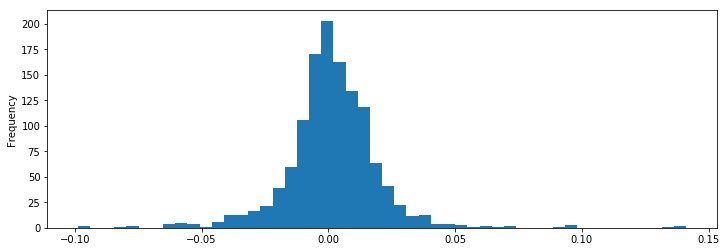

In [10]:
close_change.plot(kind='hist', bins=50, figsize=(12, 4))

### Use boolean selection to check for normality
The plot above is symmetrical and somewhat bell-shaped. It could possibly represent a normal distribution. To more formally check for normality we can count the number of observations that are within 1, 2, and 3 standard deviations. The [68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) can be used to determine if the data is approximately normal. We first need to calculate the mean and standard deviation.

In [11]:
mean = close_change.mean()
std = close_change.std()
mean.round(4), std.round(4)

(0.0016, 0.0193)

### Absolute number of standard deviations from the mean
To standardize our results we can find the number of standard deviations away from the mean each daily return is. To do this, we subtract the mean from the entire Series. We then divide by the standard deviation. This quantity is referred to as the **z-score**.

In [12]:
z_score = (close_change - mean) / std

To help make calculations easier, we will use the absolute value of the z-score.

In [13]:
z_score_abs = z_score.abs()

### Find the percentage by taking the mean
Lets' find the percentage of returns less than 1, 2, and 3 standard deviations by taking the mean of a boolean Series.

In [14]:
pct_within1 = (z_score_abs < 1).mean().round(3)
pct_within2 = (z_score_abs < 2).mean().round(3)
pct_within3 = (z_score_abs < 3).mean().round(3)

pct_within1, pct_within2, pct_within3

(0.811, 0.95, 0.979)

### Results Discussion
The percentages of returns within 1, 2 and 3 standard deviations are fairly different than the 68-95-99.7 rule. Much more of the data was concentrated within 1 standard deviation. More than 2% of the returns were greater than 3 standard deviations from the mean compared to just .3% for the rule. This strongly suggests that a normal distribution would not be a good fit for this type of data.

### Using the percentile to check for normality
Alternatively, we can work 'backwords' and find the z-score that represents the 68th, 95th, and 99.7th percentiles of the distribution. For normally distributed data, we would expect these to be 1, 2, and 3 respectively. The `quantile` method completes this operation for us. Note how far off the 68th and 99.7th percentiles are.

In [15]:
# Normal distributions return 1, 2, 3
z_score_abs.quantile([.68, .95, .997]).round(2)

0.680    0.69
0.950    1.99
0.997    5.11
Name: close, dtype: float64

### Check that all Series values are `True`
Let's say we wanted to check if all the stock price returns were within 4 standard deviations from the mean. For boolean Series, the `all` method returns `True` if all values are `True` and `False` otherwise.

In [16]:
criteria = z_score_abs < 4
criteria.head(10)

date
2014-04-14     True
2014-04-15     True
2014-04-16     True
2014-04-17     True
2014-04-21     True
2014-04-22     True
2014-04-23     True
2014-04-24     True
2014-04-25    False
2014-04-28     True
Name: close, dtype: bool

In [17]:
criteria.all()

False

We can duplicate the above logic with the `any` method. The `any` method returns `True` if one or more values in the Series are `True`. Here, we check if any of the returns are greater than or equal to 4.

In [18]:
criteria = z_score_abs >= 4
criteria.any()

True

## Exercises
Solutions are in this chapter below the exercises.

### Exercise 1
<span  style="color:green; font-size:16px">Use the IEX API to return historical stock data for the automaker Tesla (TSLA) for the last year. Assign the closing price to the Series `tsla_close`.</span>

### Exercise 2
<span  style="color:green; font-size:16px">Use one line of code to find the daily percentage returns of TSLA and drop any missing values. Save the result to `tsla_change`.</span>

### Exercise 3
<span  style="color:green; font-size:16px">Find the mean daily return for Tesla, the first and last closing prices, and the number of trading days. Store all four of these values into separate variables.</span>

### Exercise 4
<span  style="color:green; font-size:16px">If Tesla returned its mean percentage return every single day since the first day you have data, what would its last closing price be? Is it the same as the actual last closing price? You need to use all the variables calculated from Exercise 3.</span>

### Exercise 5
<span  style="color:green; font-size:16px">Find the z-score for the Tesla daily returns. Save this to a variable `z_score_raw`. What is the max and minimum score?</span>

### Exercise 6
<span  style="color:green; font-size:16px">What percentage did Tesla stock increase when it had its highest maximum raw z-score?</span>

### Exercise 7
<span  style="color:green; font-size:16px">Create a function that accepts a stock ticker symbol (amzn for example) and a date range. Use the parameters `symbol` and `date_range` both of which will be passed strings. It returns the percentage of prices within 1, 2, and 3 standard deviations from the mean. Use your function to return results for different stocks (tsla, fb, slb, gm, etc...)</span>

### Exercise 8
<span  style="color:green; font-size:16px"> How many days did Tesla close above 300 and below 350?</span>

### Exercise 9
<span  style="color:green; font-size:16px"> How many days did Tesla close below 200 or above 350?</span>

### Exercise 10
<span  style="color:green; font-size:16px"> Look up the definition for interquartile range and slice Tesla closing prices so it contains just the interquartile range. There are multiple ways to do this. Check the `quantile` method.</span>

### Exercise 11
<span  style="color:green; font-size:16px">Find the date of the highest closing price. Find out how many trading days it has been since Tesla recorded it highest closing price.</span>

## Solutions

### Exercise 1
<span  style="color:green; font-size:16px">Use the IEX API to return historical stock data for the automaker Tesla (TSLA) for the last year. Assign the closing price to the Series `tsla_close`.</span>

In [19]:
url = 'https://api.iextrading.com/1.0/stock/TSLA/chart/1y'
tsla = pd.read_json(url)
tsla = tsla.set_index('date')
tsla.head()

,change,changeOverTime,changePercent,close,high,label,low,open,unadjustedVolume,volume,vwap
date,,,,,,,,,,,
2018-04-09,-9.64,0.000000,-3.221,289.66,309.5000,"Apr 9, 18",289.21,300.3700,10249805,10249805,299.7052
2018-04-10,15.04,0.051923,5.192,304.70,307.1000,"Apr 10, 18",293.68,298.9700,11024259,11024259,302.6414
2018-04-11,-3.77,0.038908,-1.237,300.93,308.9800,"Apr 11, 18",299.66,300.7403,7482945,7482945,304.1817
2018-04-12,-6.85,0.015259,-2.276,294.08,303.9500,"Apr 12, 18",293.68,302.3200,7608769,7608769,297.3182
2018-04-13,6.26,0.036871,2.129,300.34,303.9499,"Apr 13, 18",295.98,303.6000,7327223,7327223,300.0102


In [20]:
tsla_close = tsla['close']
tsla_close.head(3)

date
2018-04-09    289.66
2018-04-10    304.70
2018-04-11    300.93
Name: close, dtype: float64

### Exercise 2
<span  style="color:green; font-size:16px">Use one line of code to find the daily percentage returns of TSLA and drop any missing values. Save the result to `tsla_change`.</span>

In [21]:
tsla_change = tsla_close.pct_change().dropna()
tsla_change.head()

date
2018-04-10    0.051923
2018-04-11   -0.012373
2018-04-12   -0.022763
2018-04-13    0.021287
2018-04-16   -0.030399
Name: close, dtype: float64

### Exercise 3
<span  style="color:green; font-size:16px">Find the mean daily return for Tesla, the first and last closing prices, and the number of trading days. Store all four of these values into separate variables.</span>

In [22]:
mean = tsla_change.mean().round(4)
first = tsla_close.iloc[0]
last = tsla_close.iloc[-1]
n = tsla_change.size
mean, first, last, n

(0.0005, 289.66, 276.06, 253)

### Exercise 4
<span  style="color:green; font-size:16px">If Tesla returned its mean percentage return every single day since the first day you have data, what would its last closing price be? Is it the same as the actual last closing price? You need to use all the variables calculated from Exercise 3.</span>

In [23]:
first * (mean + 1) ** n

328.7100998703309

In [24]:
last

276.06

### Exercise 5
<span  style="color:green; font-size:16px">Find the z-score for the Tesla daily returns. Save this to a variable `z_score_raw`. What is the max and minimum score?</span>

In [25]:
std = tsla_change.std()
z_score_raw = (tsla_change - mean) / std
z_score_raw.head()

date
2018-04-10    1.386715
2018-04-11   -0.347139
2018-04-12   -0.627323
2018-04-13    0.560552
2018-04-16   -0.833245
Name: close, dtype: float64

In [26]:
z_score_raw.max(), z_score_raw.min()

(4.664490468653098, -3.762288647595108)

Or with `agg`.

In [27]:
z_score_raw.agg(['min', 'max']).round(3)

min   -3.762
max    4.664
Name: close, dtype: float64

### Exercise 6
<span  style="color:green; font-size:16px">What percentage did Tesla stock increase when it had its highest maximum raw z-score?</span>

In [28]:
tsla_change[z_score_raw == z_score_raw.max()]

date
2018-10-01    0.173471
Name: close, dtype: float64

### Exercise 7
<span  style="color:green; font-size:16px">Create a function that accepts a stock ticker symbol (amzn for example) and a date range. Use the parameters `symbol` and `date_range` both of which will be passed strings. It returns the percentage of prices within 1, 2, and 3 standard deviations from the mean. Use your function to return results for different stocks (tsla, fb, slb, gm, etc...)</span>

In [29]:
def stock_pct_finder(symbol, date_range):
    url = f'https://api.iextrading.com/1.0/stock/{symbol}/chart/{date_range}'
    stock = pd.read_json(url)
    close = stock['close']
    close_change = close.pct_change().dropna()
    
    mean = close_change.mean()
    std = close_change.std()
    z_score_abs = (close_change - mean).abs() / std
    
    pct_within1 = (z_score_abs < 1).mean().round(3)
    pct_within2 = (z_score_abs < 2).mean().round(3)
    pct_within3 = (z_score_abs < 3).mean().round(3)

    return pct_within1, pct_within2, pct_within3

In [30]:
stock_pct_finder('amzn', '5y')

(0.811, 0.95, 0.979)

In [31]:
stock_pct_finder('fb', '1y')

(0.822, 0.968, 0.98)

In [32]:
stock_pct_finder('slb', '1y')

(0.739, 0.937, 0.996)

In [33]:
stock_pct_finder('tsla', '1y')

(0.806, 0.945, 0.98)

### Exercise 8
<span  style="color:green; font-size:16px"> How many days did Tesla close above 300 and below 350?</span>

In [34]:
filt = (tsla_close > 300) & (tsla_close < 350)
tsla_close[filt].head()

date
2018-04-10    304.70
2018-04-11    300.93
2018-04-13    300.34
2018-04-19    300.08
2018-05-02    301.15
Name: close, dtype: float64

In [35]:
tsla_close[filt].size

123

In [36]:
# or using sum method
filt.sum()

123

In [37]:
# one line
((tsla_close > 300) & (tsla_close < 350)).sum()

123

### Exercise 9
<span  style="color:green; font-size:16px"> How many days did Tesla close below 200 or above 350?</span>

In [38]:
((tsla_close < 200) | (tsla_close > 350)).sum()

24

### Exercise 10
<span  style="color:green; font-size:16px"> Look up the definition for interquartile range and slice Tesla closing prices so it contains just the interquartile range. There are multiple ways to do this. Check the `quantile` method.</span>

In [39]:
# a few ways to do this
n = tsla_close.size
first_q = n // 4
third_q = n // 4 * 3

tsla_close.sort_values().iloc[first_q:third_q].head()

date
2019-03-13    288.96
2019-04-01    289.18
2018-09-13    289.46
2018-04-09    289.66
2019-03-14    289.96
Name: close, dtype: float64

In [40]:
# using the quantile method
q1 = tsla_close.quantile(.25)
q3 = tsla_close.quantile(.75)

criteria = (tsla_close >= q1) & (tsla_close <= q3)

tsla_close[criteria].sort_values().head()

date
2019-04-01    289.18
2018-09-13    289.46
2018-04-09    289.66
2019-03-14    289.96
2018-07-30    290.17
Name: close, dtype: float64

### Exercise 11
<span  style="color:green; font-size:16px">Find the date of the highest closing price. Find out how many trading days it has been since Tesla recorded it highest closing price.</span>

In [41]:
max_close_date = tsla_close.idxmax()
max_close_date

Timestamp('2018-08-07 00:00:00')

Number of trading days

In [42]:
tsla_close.loc[max_close_date:].size

170

Number of actual days

In [43]:
tsla_close.index[-1] - max_close_date

Timedelta('246 days 00:00:00')